In [ ]:
!ls

automated_machine_learning_feature_engineering.csv  sample_data


0 duplicates are deleted. There are 1016 articles.
2020.0    479
2019.0    244
2018.0     94
2021.0     53
2017.0     31
2016.0     11
2015.0      1
Name: Year, dtype: int64


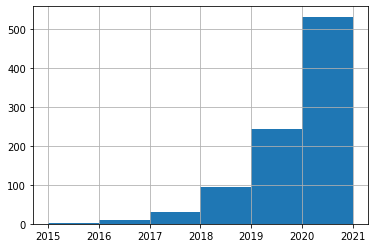

In [ ]:
import pandas as pd
import numpy as np
from gensim.summarization import keywords
import collections
import glob
import difflib

#=====================
# ПАРАМЕТРЫ
target_keyword = 'robust'  # target key-pair-word 
popularity_treschold = -1        # journals with less number of occurence are ignored
alikness_treshold = 0.99         #  
#===========================

#============ Эти слова будут выброшены из названий статей и аннотаций (abstract)
stopwords = ['',' ','a','the','et','al','in','for','of','and','as','is','to',
                 'on','can','be','pp','an','we','corr','abs','by','has','been',
                 'st','kg,','at','ijcai','iclr','this','proceedings','from',
                 'our','conference', 'such', 'th','or','with', 'that', 'like',
                  'en', 'lo', 'de','el','del', 'que', 'se', 'la', 'page', 'die','lo',
                 'pdf', 'more', 'ieee', 'but', 'use', 'permission']
spanish =[' en ', ' lo ', ' de ',' el ',' del ', ' que ', ' se ', ' la ', ' des ']


#============ Все символы, кроме букв, будут выброшены из названий журналов
def leave_only_letters(x):
     x = str(x)
     return ''.join(filter(str.isalpha, x))

#============ Из списка выбрасываем одинаковые элементы
def col2list(x):
    return list(map(str, list(set(list(x)))))

#============ Все символы, кроме букв и пробелов, будут выброшены из названий статей и аннотаций
def isalpha_or_space(xx):
    if xx == "":
        return False
    if xx.isalpha() or xx.isspace():
        return True
    return False

#============ Продсчет статистики пар последовательных слов, результат -- словарь
def keyPairs(x):
    x = str(x)
    x = ''.join(filter(isalpha_or_space, x))
    keywordz = x.lower().split(' ')

    keywordz = [x for x in keywordz if (not x in stopwords)and len(x)>1] 

    keywordz = [x if x[-1]!='s' else x[:-1] for x in keywordz] 

    all_pairs = sorted([str(y + ' ' + z) for y, z in zip(keywordz[:-1], keywordz[1:])])

    counted_pair = {}
    current = all_pairs[0] 
    counter = 0 
    for y, z in zip(all_pairs[:-1], all_pairs[1:]):
         if difflib.SequenceMatcher(None,current,z).ratio() > alikness_treshold:
             counter += 1
         else:
             counted_pair.update({current:counter})
             current = z
             counter = 1   
    return counted_pair

def keyMono(x):
    x = str(x)
    x = ''.join(filter(isalpha_or_space, x))
    keywordz = x.lower().split(' ')

    keywordz = [x for x in keywordz if (not x in stopwords)and len(x)>1] 

    keywordz = [x if x[-1]!='s' else x[:-1] for x in keywordz] 

    all_pairs = sorted(keywordz)
    print(all_pairs)
    counted_pair = {}
    current = all_pairs[0] 
    counter = 0 
    for y, z in zip(all_pairs[:-1], all_pairs[1:]):
         if difflib.SequenceMatcher(None,current,z).ratio() > alikness_treshold:
             counter += 1
         else:
             counted_pair.update({current:counter})
             current = z
             counter = 1   
    return counted_pair


#============ Считаем все csv файлы из текущей директории в df_starter
df_starter = pd.DataFrame()
for file_name in glob.glob('*.csv'):
    if file_name!='results.csv':
        x = pd.read_csv(file_name)
        df_starter = pd.concat([df_starter,x],axis=0)
#============ Оставляем только статьи напрямую относящиеся к термину target_keyword 
'''df_starter = df_starter[df_starter['Title'].str.contains(target_keyword,na=False) 
                      | df_starter['Abstract'].str.contains(target_keyword,na=False) ]'''
df = df_starter.copy()
del df_starter


#============ Оставляем только статьи из популярных журналов, регулируется параметром popularity_treschold 
df['Source'] = df['Source'].apply(leave_only_letters)
journals = df['Source'].value_counts()
filterz = {k:v for (k,v) in journals.items() if v > popularity_treschold}.keys()
df = df[df['Source'].isin(filterz)]

#============ Отбрасываем статьи на романских языках: испанский, французский и пр. 
df = df[~df['Title'].str.contains(' la ',na=False)]
df = df[~df['Title'].str.contains(' de ',na=False)]


#============ Отбрасываем время закачки информации и ее номер, затем отбрасываем повторы в статьях
df.pop('QueryDate')
df.pop('GSRank')
length = len(df)
df.drop_duplicates(inplace=True)
print(length - len(df),'duplicates are deleted. There are',len(df),'articles.') 
#============ Вывод гистограммы с количеством статей по годам
df[(df['Year']>2014) & (df['Year']<=2021)]['Year'].hist(bins=6)
#============ Запоминаем количество статей по годам на будущее
per_year_articles = df[(df['Year']>2014) & (df['Year']<=2021)]['Year'].value_counts()
print(per_year_articles)

# Данные готовы для статистической обработки
# Если выскакивает 0, то это означает, что target_keyword в ПАРАМЕТРАХ 
# в начале программы выбрано неправильно.
# Выберите СВОЙ ключевый термин в качестве значения target_keyword  

In [ ]:
# Начинается статистическая обработка
all =[]
for year in range(2015,2022):
    result = keyMono(' '.join(col2list(df[df['Year']==year]['Title']))+' '.join(col2list(df[df['Year']==year]['Abstract'])))
    
    rez = sorted(result.items(), key=lambda x: x[1], reverse=True)
    all += [[ke,va,year] for ke,va in rez if va>2 ]

    print(year, '========')
    print([[ke,va,year] for ke,va in rez if va>2 ])
    print('===============')

['download', 'google', 'info', 'material', 'material', 'materialusa', 'method', 'method', 'method', 'new', 'new', 'new', 'number', 'patent', 'publication', 'searching', 'searching', 'searching', 'system', 'system', 'system', 'usa', 'usa']
2015 ========
[['method', 3, 2015], ['new', 3, 2015], ['searching', 3, 2015], ['system', 3, 2015]]
['algorithm', 'architecture', 'architecture', 'architecture', 'architecture', 'architecture', 'architecture', 'architecture', 'architecture', 'architecture', 'architecture', 'art', 'arxiv', 'arxiv', 'arxiv', 'arxiv', 'arxivnan', 'arxivv', 'bello', 'black', 'box', 'chine', 'combinatorial', 'combinatorial', 'connectionist', 'csai', 'eprint', 'function', 'global', 'gradientfollowing', 'hieu', 'irwan', 'jan', 'le', 'le', 'le', 'learn', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'learning', 'ma', 'mohammad', 'neural', 'neural', 'neural'

In [ ]:
# Cтатистика обрабатывается по годам
rs = pd.DataFrame(all)
terms = list(rs[0].unique())
termf = []
for term in terms:
   part = rs[rs[0]==term][[1,2]]
   part = part.set_index(2)
   termf.append(part.T)
termf = pd.concat(termf)
termf['terms'] = terms
# Вычисляем среднее число
termf['average'] = termf[[2016,2017,2018,2019,2020]].mean(axis=1)
termf = termf[['terms', 2016, 2017, 2018,2019,2020,'average']].fillna(0)
for year in range(2016,2021):
  termf[year] = termf[year].astype(int)
termf = termf.sort_values(by='average', ascending=False)

def trendz2(x):
    x = list(x)
    length, xarr = len(x), np.array(x) 
    if len(x)<0.001 or sum(x)<0.001:
       return 0.0   
    vec1 = (xarr*length-sum(x)*np.ones(length))/sum(x)/length
    vec2 = (np.array(list(range(length))) - np.ones(length)*length/2)/length/(length+1)
    return int(round(np.dot(vec1,vec2)*1000)) 

termf['trend2'] = termf[[2016,2017,2018,2019,2020]].apply(trendz2,axis=1) 

In [ ]:
 termf.describe()

2,2016,2017,2018,2019,2020,average,trend2
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,0.059625,0.368825,1.078365,3.724020,8.660988,6.423992,53.317717
std,0.809063,2.287014,4.762634,14.840688,27.734170,10.346096,18.696720
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-33.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,46.000000
50%,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,60.000000
75%,0.000000,0.000000,0.000000,4.000000,7.000000,6.000000,67.000000
max,15.000000,38.000000,75.000000,263.000000,496.000000,176.400000,67.000000


In [ ]:
termf.to_csv('results.csv',index=False)

In [ ]:
# for year in range(2015,2021):
#      termf[year] = termf[year]/per_year_articles[year*1.0]

# termf['trend3'] = termf[[2015,2016,2017,2018,2019]].apply(trendz2,axis=1)
# termf['weightedtrend3'] = termf['trend3']+termf['average'] 

In [ ]:
'''machine learning
deep learning
architecture search	
hyperparameter optimization
bayesian optimization
robust
graph neural
search space	
transfer learning
time series
federated learning
random search	
cardiovascular disease	
computer vision
feature engineering	
recommender system	
knowledge graph	
natural language 
language processing
image segmentation	
bilinear graph	
'''
rez = termf.sort_values(by='average', ascending=False)
rez[(rez['average']>5)&(rez['trend2']>0)&(rez['terms'].apply(len)<3000)][40:].head(40)


2,terms,2016,2017,2018,2019,2020,average,trend2
1,framework,0,0,5,14,36,18.333333,52.0
1,journal,0,0,0,0,18,18.000000,67.0
1,automatic,0,0,0,9,27,18.000000,58.0
1,metalearning,0,0,0,17,18,17.500000,50.0
1,based,0,3,7,19,41,17.500000,47.0
1,parameter,0,0,4,11,37,17.333333,54.0
1,simulation,0,0,0,0,17,17.000000,67.0
1,information,0,0,11,16,24,17.000000,42.0
1,toward,0,0,0,13,20,16.500000,54.0
1,function,0,0,0,11,22,16.500000,56.0


In [ ]:
for year in range(2015,2021):
     termf['norm'+str(year)] = termf[year]/per_year_articles[year*1.0]*1000
for year in range(2015,2021):
     termf['norm'+str(year)] = termf['norm'+str(year)].astype(int)
for year in range(2015,2021):
     termf['norm'+str(year)] = termf['norm'+str(year)].astype(float)/10


termf['trend3'] = termf[['norm2015','norm2016','norm2017','norm2018','norm2019','norm2020']].apply(trendz2,axis=1)
termf['weightedtrend3'] = termf['trend3']+termf['average'] 

In [ ]:
pd.options.display.float_format = '{:,.1f}'.format
termf.sort_values(by='average',ascending=False)[:30][['terms',2015,2016,2017,2018,2019,2020,'average','norm2015','norm2016','norm2017','norm2018','norm2019','norm2020','trend3']].to_csv('d.csv')
